# Data Management with Kosh

After generating data with Maestro or Merlin we need to access the data in our Kosh/Sina store. After some data manipulation we can train a surrogate model to emulate the Pyranda physics calculations.

The Kosh store gives us the convenience of saving all the variables and outputs with the associated metadata. Instead of saving varibales like the Atwood number and velocity-magnitude in the filenames we can save all the information we need in the metadata. Then it's convenient to find in our ensemble later. 

In [1]:
import numpy as np
import matplotlib
import kosh
import os
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize


# Connect to the Kosh store
store_dir = os.path.join(os.getcwd(), "RT_UQ/pyranda.sql")
store = kosh.connect(store_dir)

# Create an ensemble or use an existing one
# We can associate all our datasets and images with this ensemble
name = "RT_UQ"
try:
    ensemble = next(store.find_ensembles(name=name))
except Exception:
    # Does not exist yet
    ensemble = store.create_ensemble(name=name)

print(f"ensemble: {ensemble}")

ensemble: KOSH ENSEMBLE
	id: 9b1263add8a2408cac84466369c9f88b
	name: RT_UQ
	creator: olson59

--- Attributes ---
	creator: olson59
	name: RT_UQ
--- Associated Data (5)---
	Mime_type: pandas/csv
		/usr/WS2/olson59/weave/weave_docs/docs/tutorials/Public/pyranda_rayleigh_taylor/RT_UQ/plot-all/rt_sim_data.csv ( 325e681a00df4d29ac0f3320aa236b22 )
	Mime_type: png
		/usr/WS2/olson59/weave/weave_docs/docs/tutorials/Public/pyranda_rayleigh_taylor/RT_UQ/plot-all/GP_at_60.0_s.png ( 2c1f0f212db047c28bb1b7d025e320c5 )
		/usr/WS2/olson59/weave/weave_docs/docs/tutorials/Public/pyranda_rayleigh_taylor/RT_UQ/plot-all/LOO_at_60.0_s.png ( 3a2af4ca4c9c4e82a9bb025bf8f78d23 )
		/usr/WS2/olson59/weave/weave_docs/docs/tutorials/Public/pyranda_rayleigh_taylor/RT_UQ/plot-all/all_mixing_width.png ( fd3c8905a90144e382b486547c638b05 )
		/usr/WS2/olson59/weave/weave_docs/docs/tutorials/Public/pyranda_rayleigh_taylor/RT_UQ/plot-all/atwood_vs_vel.png ( 7261bdfa6597415881dbf0857ef7e1b1 )
--- Member Datasets (100)---
	

## Gathering variables from each simulation run

We can loop through the datasets in our Kosh store, and save the inputs and outputs from time = 60.0 seconds. Data of all different types can be associated together in our ensemble.

Data size: (100, 3)
First 5 rows
[[0.507      0.888      5.93314917]
 [0.529      1.057      6.39352576]
 [0.343      0.881      3.79692963]
 [0.44       1.074      5.45508558]
 [0.477      0.996      5.63511786]]


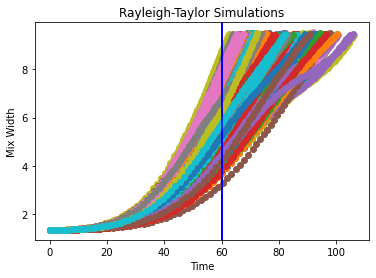

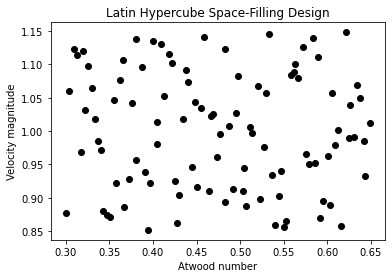

In [2]:
sample_time = 60.0
samples = []
N_cases = len(list(store.find(types="pyranda", run_type="sim", ids_only=True)))
for i, case in enumerate(store.find(types="pyranda", run_type="sim"), start=1):
    # Let's add this dataset to our ensemble
    #print("*********************************")
    #print("DS:", case.id)
    #print("*********************************")
    ensemble.add(case)

    # Let's retrieve the variables of interest
    time = case["variables/time"][:] # Time
    width = case["variables/mixing width"][:] # Width
    mixed = case["variables/mixedness"][:] # Mixedness
    atwood = case.atwood_number
    velocity = case.velocity_magnitude
    lbl = f"Vel: {velocity} - At: {atwood}"
    plt.figure(2)
    plt.plot(time, width, "-o", label=lbl)
    plt.axvline(x=60.0, color='b', label="60 s")
    plt.xlabel("Time")
    plt.ylabel("Mix Width")
    plt.title("Rayleigh-Taylor Simulations")
    if i == N_cases:
        fnm = "all_mixing_width.png"
        ensemble.associate(fnm, "png", metadata={"title": lbl})

    # Plotting to show the input sampling design
    plt.figure(1)
    plt.plot(atwood, velocity, 'ko')
    plt.xlabel("Atwood number")
    plt.ylabel("Velocity magnitude")
    plt.title("Latin Hypercube Space-Filling Design")
    if i == N_cases:
        fnm = "atwood_vs_vel.png"
        ensemble.associate(fnm, "png", metadata={"title":'atwood vs velocity'})
            
    # For each time, qoi
    #  Sample = [atwood, velocity, width]
    sample_width = np.interp(sample_time, time, width)
    samples.append([atwood, velocity, sample_width])
    
samples = np.array(samples)

# Save for next step
header = "# 'atwood' 'velocity' "
header += " 'width-0' "
fnm = "rt_sim_data.csv"
np.savetxt(fnm, samples, delimiter=',',header=header)
#associate with ensemble
ensemble.associate(fnm, "pandas/csv", metadata={"gp_data":True})

print(f"Data size: {samples.shape}")
print("First 5 rows")
print(samples[:5])

## Fitting the Gaussian Process (GP) Models

We will fit a Gaussian process surrogate model for each time we chose from the simulation. This model will need to be able to predict mixing width very quickly and accurately. The Gaussian process model can return a prediction and a standard error estimate. The error should be very small for data points it was trained on, and larger when it has to interpolate between training data points. 

In [4]:
# We need an array of model inputs for the GP
xgp = samples[:, 0:2]

# The GP model performs better when the inputs are scaled
scaler = MMS()
scaled_samples = scaler.fit_transform(xgp)

# Get inputs for 2D plots
# We're going to evaluate the model at points it was not trained on
atwoods = np.linspace(.25, .75, 100)
velocities = np.linspace(.75, 1.25, 100)
at2d, vel2d = np.meshgrid(atwoods, velocities)
atwoods = at2d.flatten().reshape(-1, 1)
velocities = vel2d.flatten().reshape(-1, 1)
inputs = np.concatenate( (atwoods, velocities), axis=1 )
scaled_inputs = scaler.transform(inputs)

## Plotting the GP Predictions

Here we're going to evaluate the model at many inputs to see how well it can predict mixing width. The mix width prediction is shown as a blue response surface over the Atwood and velocity values. The color of the surface indicates low error blue to high error red. The error is very low in the areas where the model was trained, but we forced to model to predict outside of the range it was trained on and you can see the error increases at the corners where it did not have traning data.

'77baaf1924e04c78aab6083d53b7dae8'

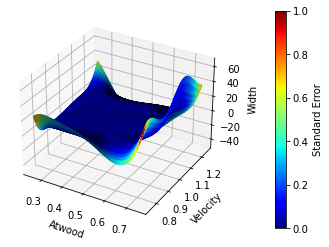

In [5]:
# Fitting a GP model at 60.0 sec in simulation
y = samples[:, 2]
# ConstantKernel(1.0) * RBF(1.63)
kernel = 1.95 * RBF(1.0, length_scale_bounds="fixed")
GP_model = GPR(kernel=kernel, normalize_y=False)
GP_model.fit(scaled_samples, y)

# See GP prediction in 2D
pred, std = GP_model.predict(scaled_inputs, return_std=True)

fig = plt.figure(3)
ax = fig.add_subplot(111, projection='3d')
pred2d = pred.reshape(at2d.shape)
std2d = std.reshape(at2d.shape)
mycol = cm.jet((std2d - std.min()) / (std.max() - std.min()))
cmap = plt.colormaps["jet"]
plot = ax.plot_surface(at2d, vel2d, pred2d, facecolors=mycol)
fig.colorbar(cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax, label="Standard Error", pad=0.15)
ax.set_xlabel('Atwood')
ax.set_ylabel('Velocity')
ax.set_zlabel('Width')
fnm = f"GP_at_{sample_time}_s.png"
ensemble.associate(fnm, "png", metadata={"title":'2D GP'})

## Leave-One-Out Cross Validation

We can evaluate the GP model with a leave-one-out method where a model is trained on all the data except the first data point, next we train a model on all but the second data point, etc. Each time we train a model we evaluate it on the data point that was left out. It's ok to use in this situation because our model is fast to train and predict. 

MSE at 60 s: [0.12466071]


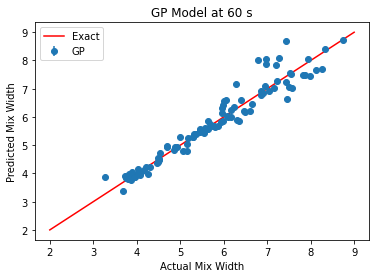

In [6]:
loo = LeaveOneOut()

y = samples[:, 2]

loo_pred = []
loo_bar = []
loo_sqerror = []
for i, (train_index, test_index) in enumerate(loo.split(scaled_samples)):
    gp_model = GPR(kernel=kernel)
    gp_model.fit(scaled_samples[train_index, :], y[train_index])
    pred, std = gp_model.predict(scaled_samples[test_index, :], return_std=True)
    loo_pred.append(pred)
    loo_bar.append((pred + std * 1.96) - (pred - std * 1.96))
    loo_sqerror.append((y[test_index] - pred)**2)
plt.figure(4)
plt.errorbar(y.flatten(), np.array(loo_pred).flatten(), yerr=np.array(loo_bar).flatten(), fmt='o',label='GP')
plt.plot([2, 9],[2, 9],'r-',label="Exact")
plt.xlabel("Actual Mix Width")
plt.ylabel("Predicted Mix Width")
plt.title("GP Model at 60 s")
plt.legend()
print(f"MSE at 60 s: {sum(loo_sqerror)/len(loo_sqerror)}")